In [1]:
import copy
import importlib
import os
import warnings
from itertools import product

import torch
from dotenv import load_dotenv
from lightning.pytorch import Trainer, seed_everything
from lightning.pytorch import loggers as pl_loggers
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from lightning.pytorch.tuner import Tuner
from tqdm.auto import tqdm

load_dotenv("../env")

warnings.filterwarnings("ignore", ".*does not have many workers.*")

In [2]:
import luminar.document.data
import luminar.document.model
import luminar.features
import luminar.mongo

importlib.reload(luminar.document.data)
importlib.reload(luminar.document.model)
importlib.reload(luminar.features)
importlib.reload(luminar.mongo)

<module 'luminar.mongo' from '/nvme/projects/PrismAI/PrismAI/src/luminar/mongo.py'>

In [4]:
from luminar.document.data import (
    DocumentClassificationDataModule,
    FeatureDataset,
    PaddingDataloader,
    n_way_split,
)
from luminar.document.model import ConvolutionalLayerSpec, DocumentClassficationModel
from luminar.features import FeatureExtractor, OneDimFeatures, Slicer, TwoDimFeatures
from luminar.mongo import PrismaiDataset

In [5]:
domains = {
    "Blog Authorship": {"domain": "blog_authorship_corpus"},
    "Student Essays": {"domain": "student_essays"},
    "CNN News": {"domain": "cnn_news"},
    "Euro Court Cases": {"domain": "euro_court_cases"},
    "House of Commons": {"domain": "house_of_commons"},
    "ArXiv Papers": {"domain": "arxiv_papers"},
    "Gutenberg": {"domain": "gutenberg", "lang": "en-EN"},
    "Bundestag [DE]": {"domain": "bundestag"},
    "Spiegel [DE]": {"domain": "spiegel_articles"},
    # "Gutenberg [DE]": {"domain": "gutenberg", "lang": "de-DE"},
}
dmap = {
    "Blog Authorship": "Blog Authorship",
    "Student Essays": "Student Essays",
    "CNN News": "CNN News",
    "Euro Court Cases": "Euro Court Cases",
    "House of Commons": "House of Commons",
    "ArXiv Papers": "ArXiv Papers",
    "Gutenberg [EN]": "Gutenberg",
    "Bundestag": "Bundestag [DE]",
    "Spiegel": "Spiegel [DE]",
    # "Gutenberg [DE]": 
}

In [6]:
config = {
    "seed": 1337,
    "eval_split": 0.1,
    "test_split": 0.1,
    "feature_model": "gpt2",
    "synth_agent": "gpt-4o-mini",
    # "synth_agent": "gemma2:9b"
}

In [40]:
dataset = PrismaiDataset(
    mongo_db_connection=os.environ.get("MONGO_DB_CONNECTION"),
    database="prismai",
    collection="features_prismai",
    feature_model=config["feature_model"],
    synth_agent=config["synth_agent"],
    synth_type={"$in": ("source", "fulltext")},
    update_cache=True,
    **domains["CNN News"],
).load()

[PrismaiDataset] Loading Documents from MongoDB: 1500it [00:19, 76.84it/s]


[PrismaiDataset] Writing Cache File /tmp/luminar/2982044d5332b295e5e8e3a5a6291d2757ee5843d7d6cbba05f6a53d57500b50.pkl


In [8]:
# feature_dim = OneDimFeatures(256)
# featurizer = FeatureExtractor.Likelihood()
# featurizer = FeatureExtractor.LogLikelihoodLogRankRatio()
# second_dim_as_channels = False

In [41]:
feature_dim = TwoDimFeatures(256, 13)
# featurizer = FeatureExtractor.LikelihoodTopkLikelihoodRatio(13)
featurizer = FeatureExtractor.IntermediateLogits(13)
second_dim_as_channels = True

In [73]:
slicer = Slicer.First(feature_dim[0])
# slicer = Slicer.Random(feature_dim[0])
# slicer = Slicer.RandomMultiple(feature_dim[0] // 4, multiple=4, stride=16)
# slicer = Slicer.RandomMultiple(feature_dim[0] // 4, 4)

In [44]:
featurized_dataset = FeatureDataset(dataset, slicer, featurizer, label_field="type", label_zero="source")

### Feature Visualization

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from transition_scores.data import FeatureValues

In [201]:
def visualize_features(ai_features: np.ndarray):
    fig = plt.imshow(
        ai_features,
        cmap=sns.cubehelix_palette(as_cmap=True),
        vmin=min(0.0, ai_features.min()),
        vmax=max(1.0, ai_features.max()),
    )
    fig.axes.set_axis_off()
    plt.tight_layout()
    return fig

In [216]:
sample = dataset[0]

In [ ]:
ai_sample = (
    sample["features"][0]
    if sample["features"][0]["type"] != "source"
    else sample["features"][1]
)
ai_ts = FeatureValues(**ai_sample["transition_scores"])

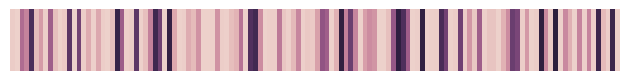

In [336]:
visualize_features(FeatureExtractor.Likelihood().featurize(
    ai_ts, slices=[slice(0, 128)]
).view(1, -1).numpy().repeat(13, axis=0))
plt.savefig("../figures/features/example_cnn_news_0/ai_likelihood.png", bbox_inches="tight", pad_inches=0)
plt.show()

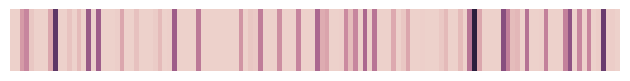

In [356]:
visualize_features(FeatureExtractor.LogLikelihoodLogRankRatio().featurize(
    ai_ts, slices=[slice(0, 128)]
).neg().view(1, -1).numpy().repeat(13, axis=0))
plt.savefig("../figures/features/example_cnn_news_0/ai_llrr.png", bbox_inches="tight", pad_inches=0)
plt.show()

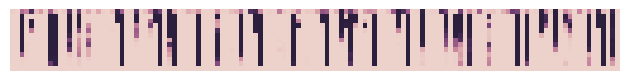

In [338]:
visualize_features(FeatureExtractor.IntermediateLogits(13).featurize(
    ai_ts, slices=[slice(0, 128)]
).T.numpy())
plt.savefig("../figures/features/example_cnn_news_0/ai_il.png", bbox_inches="tight", pad_inches=0)
plt.show()

In [339]:
# visualize_features(
#     FeatureExtractor.TopkLikelihoodLikelihoodRatio(13)
#     .featurize(ai_ts, slices=[slice(0, 128)])
#     .T.numpy()
# )
# plt.savefig("../figures/features/example_cnn_news_0/ai_tkllr.png", bbox_inches="tight", pad_inches=0)
# plt.show()

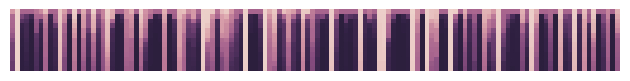

In [340]:
visualize_features(
    FeatureExtractor.LikelihoodTopkLikelihoodRatio(13)
    .featurize(ai_ts, slices=[slice(0, 128)])
    .T.numpy()
)
plt.savefig("../figures/features/example_cnn_news_0/ai_ltklr.png", bbox_inches="tight", pad_inches=0)
plt.show()

In [ ]:
human_sample = (
    sample["features"][0]
    if sample["features"][0]["type"] == "source"
    else sample["features"][1]
)
human_ts = FeatureValues(**human_sample["transition_scores"])[35:]

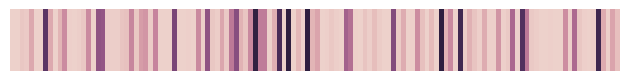

In [342]:
visualize_features(FeatureExtractor.Likelihood().featurize(
    human_ts, slices=[slice(0, 128)]
).view(1, -1).numpy().repeat(13, axis=0))
plt.savefig("../figures/features/example_cnn_news_0/human_likelihood.png", bbox_inches="tight", pad_inches=0)
plt.show()

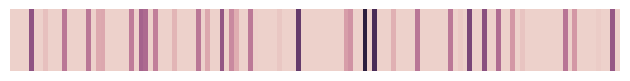

In [355]:
visualize_features(FeatureExtractor.LogLikelihoodLogRankRatio().featurize(
    human_ts, slices=[slice(0, 128)]
).neg().view(1, -1).numpy().repeat(13, axis=0))
plt.savefig("../figures/features/example_cnn_news_0/human_llrr.png", bbox_inches="tight", pad_inches=0)
plt.show()

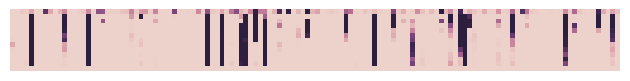

In [344]:
visualize_features(FeatureExtractor.IntermediateLogits(13).featurize(
    human_ts, slices=[slice(0, 128)]
).T.numpy())
plt.savefig("../figures/features/example_cnn_news_0/human_il.png", bbox_inches="tight", pad_inches=0)
plt.show()

In [345]:
# visualize_features(
#     FeatureExtractor.TopkLikelihoodLikelihoodRatio(13)
#     .featurize(human_ts, slices=[slice(0, 128)])
#     .T.numpy()
# )
# plt.savefig("../figures/features/example_cnn_news_0/human_tkllr.png", bbox_inches="tight", pad_inches=0)
# plt.show()

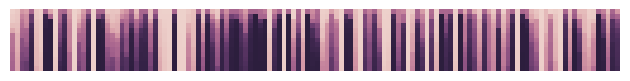

In [346]:
visualize_features(
    FeatureExtractor.LikelihoodTopkLikelihoodRatio(13)
    .featurize(human_ts, slices=[slice(0, 128)])
    .T.numpy()
)
plt.savefig("../figures/features/example_cnn_news_0/human_ltklr.png", bbox_inches="tight", pad_inches=0)
plt.show()

In [347]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("gpt2")

In [348]:
import pandas as pd

pd.DataFrame(
    [
        [token, *probs]
        for token, probs in zip(
            tokenizer.batch_decode(ai_ts.target_ids),
            ai_ts.intermediate_probs,
        )
    ]
)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,a,0.026336,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.139408e-32,5.317110e-08,0.000012
1,sun,0.000015,0.000000e+00,1.261169e-44,3.742329e-30,1.254021e-23,1.792270e-19,5.902366e-16,3.004399e-14,8.164120e-13,1.392371e-11,1.559337e-10,8.053550e-11,0.000026
2,-,0.468396,1.000000e+00,1.000000e+00,1.000000e+00,9.999999e-01,9.999967e-01,9.997943e-01,9.996145e-01,9.924213e-01,5.374100e-01,1.864929e-02,7.276817e-03,0.000005
3,d,0.353427,4.186039e-15,1.831974e-02,1.620275e-05,1.793188e-06,2.202149e-07,3.671529e-06,1.515408e-02,1.206673e-02,4.432150e-03,3.995220e-03,4.414768e-04,0.000251
4,renched,0.874959,4.530889e-33,9.996840e-01,9.959608e-01,3.891775e-01,7.655050e-06,6.435337e-07,4.401236e-07,2.863270e-08,2.517954e-07,8.802203e-08,1.180688e-11,0.000026
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1018,Prince,0.113689,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,6.025583e-44,7.364384e-41,3.288824e-33,1.432119e-31,2.486495e-29,4.698886e-29,2.585395e-25,0.000024
1019,George,0.840089,2.543194e-18,1.087465e-02,2.264834e-08,8.926132e-07,5.135373e-13,1.992751e-15,6.743022e-15,2.154410e-14,2.980387e-13,2.455993e-13,2.345245e-09,0.000025
1020,was,0.261998,8.285226e-10,3.309402e-06,6.243696e-10,1.858463e-15,2.947241e-15,2.211681e-14,1.652415e-10,5.307612e-12,2.960384e-10,5.502879e-10,6.610257e-08,0.000009
1021,not,0.032016,1.652814e-24,2.040415e-13,6.194701e-08,4.690743e-06,3.808291e-05,1.944895e-04,2.384681e-03,1.020173e-04,4.976589e-06,1.634923e-05,1.163587e-04,0.000050


In [349]:
import pandas as pd

pd.DataFrame(
    [
        [token, *probs]
        for token, probs in zip(
            tokenizer.batch_decode(human_ts.target_ids),
            human_ts.intermediate_probs,
        )
    ]
)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,The,0.003409,5.650764e-26,6.119600e-24,2.156183e-18,7.029320e-11,1.526468e-07,4.682826e-03,1.801080e-01,1.161997e-02,7.963005e-04,1.174424e-04,2.528330e-05,0.000046
1,Royal,0.001531,0.000000e+00,8.127531e-44,1.067438e-32,1.057411e-26,8.803607e-20,3.975745e-15,1.511499e-17,3.359892e-17,9.815635e-17,5.247652e-16,5.240966e-15,0.000036
2,Family,0.045116,0.000000e+00,1.912360e-31,1.075177e-21,5.289847e-16,2.605952e-11,4.700025e-11,3.345940e-10,4.944302e-09,4.103598e-09,8.310451e-09,4.123086e-08,0.000026
3,and,0.029514,6.691439e-08,1.213804e-06,2.795724e-07,1.416021e-07,5.512431e-06,3.564975e-05,1.048246e-04,6.083147e-04,1.458154e-03,3.193941e-03,4.212401e-03,0.000006
4,the,0.180232,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,9.999986e-01,9.999945e-01,9.999546e-01,9.999598e-01,9.998537e-01,9.996015e-01,9.994874e-01,0.000615
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
983,outfit,0.019620,1.401298e-45,3.610694e-34,1.830796e-41,3.643376e-44,1.340054e-37,1.128915e-35,1.737940e-32,4.755025e-33,7.213765e-28,1.590997e-28,1.991748e-20,0.000002
984,",",0.190685,1.000000e+00,1.000000e+00,1.000000e+00,9.999996e-01,9.999952e-01,9.998404e-01,9.989795e-01,9.998241e-01,9.989171e-01,9.979436e-01,9.788310e-01,0.000002
985,with,0.137074,2.508431e-01,9.687590e-01,2.941046e-06,5.607610e-06,4.670033e-07,9.044629e-07,1.487787e-07,4.500867e-08,6.434614e-08,2.792125e-08,1.769342e-07,0.000500
986,a,0.415560,1.000000e+00,9.999995e-01,9.650338e-01,3.285362e-01,7.683222e-02,3.490645e-02,1.351992e-02,2.418969e-03,1.237900e-03,5.406515e-04,1.976083e-03,0.000155


In [350]:
tokenizer.decode(human_ts.target_ids[:129])

" The Royal Family and the Middletons put up a united fashion front at the christening of Prince George at St James's Palace in London yesterday. All wore shades of chic cream or royal blue for the event with the Duchess of Cambridge, the Duchess of Cornwall, Pippa Middleton - and of course Prince George! - all sporting off-white. Zara and the Queen picked shades of navy and powder-blue and Carole Middleton wore a mixture of the two, in a navy coat and cream dress. Scroll down for video . Traditional gown: Kate co-ordinated her colour with that of her son, who was"

In [351]:
raise RuntimeError("STOP")

RuntimeError: STOP

In [ ]:
import os

import pymongo
from dotenv import load_dotenv
from pymongo import MongoClient
from tqdm import tqdm

load_dotenv("../env")
client = MongoClient(os.environ.get("MONGO_DB_CONNECTION"))
db = client.get_database("prismai")

In [ ]:
collection_transition_scores = db.get_collection("test_swt")

In [ ]:
from simple_dataset import Dataset
from transition_scores.data import FeaturesDict, FeatureValues

dataset = Dataset(
    FeaturesDict.new(**document) for document in collection_transition_scores.find()
)
len(dataset)

In [ ]:
dataset.apply(FeatureValues.merge, "transition_scores")
type(dataset[0]["transition_scores"])

In [ ]:
grouped_dataset = dataset.map(
    lambda doc: {"doc_id": doc["document"]["_id"]} | doc,
    in_place=False,
).group_documents_by(
    "doc_id",
    remainder_into="documents",
    in_place=True,
)

In [ ]:
[len(group["documents"]) for group in grouped_dataset]

In [ ]:
from itertools import islice

import numpy as np
from matplotlib import pyplot as plt

In [ ]:
def get_oracle_ts(
    seq_len=1024,
    vocab_size=128,
    top_k=10,
) -> FeatureValues:
    target_ids = np.random.choice(vocab_size, seq_len, replace=True).tolist()
    target_probs = (np.arange(seq_len) / seq_len).tolist()
    target_ranks = np.random.choice(vocab_size, seq_len, replace=True).tolist()
    top_k_ids = [
        np.random.choice(vocab_size, top_k, replace=False) for _ in range(seq_len)
    ]
    top_k_probs = [
        list(sorted((np.random.rand(top_k) / 10).tolist(), reverse=True))
        for _ in range(seq_len)
    ]
    return FeatureValues(
        target_ids,
        target_probs,
        target_ranks,
        top_k_ids,
        top_k_probs,
    )

In [ ]:
def viz2d(features: np.array, vmin=None, vmax=None):
    fig = plt.imshow(features, cmap="gray", vmin=vmin, vmax=vmax)
    fig.axes.set_axis_off()
    return fig

In [ ]:
def features_2d_likelihood(
    transition_scores: FeatureValues,
    w: int,
    h: int,
    skip: int = 1,
    no_overlap: bool = False,
    take_first: bool = False,
    sort_slices: bool = True,
):
    if no_overlap:
        raise NotImplementedError("no_overlap not implemented")

    size = len(transition_scores) - skip - w
    if size < w:
        raise ValueError(
            f"Sequence is too short: ({len(transition_scores)} - {skip} - {w}) < {w}"
        )

    if take_first:
        offsets = np.arange(skip, size, w)[:h]
        if not sort_slices:
            offsets = np.random.permutation(offsets)
    else:
        offsets = np.random.choice(size, h, replace=False) + skip
        if sort_slices:
            offsets = np.sort(offsets)

    features = np.zeros((h, w))
    for i, offset in enumerate(offsets):
        features[i] = transition_scores.target_probs[offset : offset + w]

    return features

In [ ]:
features = features_2d_likelihood(dataset[3]["transition_scores"], 32, 16, take_first=True)
viz2d(features)
plt.show()

features = features_2d_likelihood(dataset[-1]["transition_scores"], 32, 16, take_first=True)
viz2d(features)
plt.show()

In [ ]:
def viz3d(features: np.array, vmin=None, vmax=None):
    vmin = vmin or features.min()
    vmax = vmax or features.max()

    h, w, d = features.shape
    d = int(np.ceil(np.sqrt(d)))
    fig, axes = plt.subplots(d, d, figsize=(5, h / w * 5))
    for i, ax in enumerate(axes.flat):
        if i < features.shape[-1]:
            ax.imshow(features[..., i], cmap="gray", vmin=vmin, vmax=vmax)
        ax.set_axis_off()
    return fig

In [ ]:
from warnings import warn


def features_3d_liklihood_topk_stack(
    transition_scores: FeatureValues,
    w: int,
    h: int,
    d: int,
    skip: int = 1,
    take_first: bool = False,
    no_overlap: bool = False,
    remove_target: bool = True,
    sort_slices: bool = True,
    log: bool = False,
):
    if no_overlap:
        raise NotImplementedError("no_overlap not implemented")

    size = len(transition_scores) - skip - w
    if size < w:
        raise ValueError(
            f"Sequence is too short: ({len(transition_scores)} - {skip} - {w}) < {w}"
        )
    if size < w * h:
        warn(
            f"Sequence very short, will produce overlapping offsets: ({len(transition_scores)} - {skip} - {w}) = {size} < {w * h}"
        )
    ts = transition_scores[skip:]

    if take_first:
        offsets = np.arange(0, size, w)[:h]
        if not sort_slices:
            offsets = np.random.permutation(offsets)
    else:
        offsets = np.random.choice(size, h, replace=False) + skip
        if sort_slices:
            offsets = np.sort(offsets)

    top_k_probs = [
        list(
            islice(
                (
                    prob
                    for top_id, prob in zip(top_ids, top_probs)
                    if not remove_target or top_id != tgt_id
                ),
                d - 1,
            )
        )
        for tgt_id, top_ids, top_probs in zip(
            ts.target_ids,
            ts.top_k_indices,
            ts.top_k_probs,
        )
    ]
    top_k_probs = np.array(top_k_probs)

    features = np.empty((h, w, d))
    for i, offset in enumerate(offsets):
        features[i, :, 0] = ts.target_probs[offset : offset + w]
        features[i, :, 1:] = top_k_probs[offset : offset + w]  # [:, ::-1]
    if log:
        features = np.log1p(features)
    return features


In [ ]:
ts = get_oracle_ts()
features = features_3d_liklihood_topk_stack(ts, 16, 16, 4, take_first=True)
viz3d(features)
plt.show()

In [ ]:
features = features_3d_liklihood_topk_stack(
    dataset[3]["transition_scores"], 32, 16, 9, take_first=True,
    log="log_ratio"
)
viz3d(features)
plt.show()

mn, mx = features.min(), features.max()

features = features_3d_liklihood_topk_stack(
    dataset[-1]["transition_scores"], 32, 16, 9, take_first=True,
    log="log_ratio"
)
viz3d(features, vmin=mn, vmax=mx)
plt.show()

In [ ]:
from typing import Literal


def features_3d_likelihood_top_k_ratio(
    transition_scores: FeatureValues,
    w: int,
    h: int,
    d: int,
    skip: int = 1,
    take_first: bool = False,
    no_overlap: bool = False,
    sort_slices: bool = True,
    log: None | Literal["log_ratio", "ratio_of_logs"] = None,
):
    if no_overlap:
        raise NotImplementedError("no_overlap not implemented")

    size = len(transition_scores) - skip - w
    if size < w:
        raise ValueError(
            f"Sequence is too short: ({len(transition_scores)} - {skip} - {w}) < {w}"
        )
    if size < w * h:
        warn(
            f"Sequence very short, will produce overlapping offsets: ({len(transition_scores)} - {skip} - {w}) = {size} < {w * h}"
        )
    ts = transition_scores[skip:]

    if take_first:
        offsets = np.arange(0, size, w)[:h]
        if not sort_slices:
            offsets = np.random.permutation(offsets)
    else:
        offsets = np.random.choice(size, h, replace=False) + skip
        if sort_slices:
            offsets = np.sort(offsets)

    top_k_probs = [
        list(
            islice(
                (prob for top_id, prob in zip(top_ids, top_probs) if top_id != tgt_id),
                d,
            )
        )
        for tgt_id, top_ids, top_probs in zip(
            ts.target_ids,
            ts.top_k_indices,
            ts.top_k_probs,
        )
    ]
    top_k_probs = np.array(top_k_probs)
    target_probs = np.array(ts.target_probs).reshape(-1, 1)

    if log == "ratio_of_logs":
        top_k_probs = np.log(top_k_probs)
        target_probs = np.log(target_probs)

    features = np.empty((h, w, d))
    for i, offset in enumerate(offsets):
        features[i, :, :] = np.true_divide(
            target_probs[offset : offset + w],
            top_k_probs[offset : offset + w],
        )
        if log == "log_ratio":
            features[i, :, :] = np.log(features[i, :, :])

    return features


In [ ]:
human = features_3d_likelihood_top_k_ratio(
    dataset[3]["transition_scores"],
    32,
    16,
    9,
    take_first=True,
    # log="log_ratio",
)
viz3d(human)
plt.show()

ai = features_3d_likelihood_top_k_ratio(
    dataset[-1]["transition_scores"],
    32,
    16,
    9,
    take_first=True,
    # log="log_ratio",
)
viz3d(ai, vmin=human.min(), vmax=human.max())
plt.show()

In [ ]:
viz2d(human.reshape(-1, 9).T)
plt.show()

viz2d(ai.reshape(-1, 9).T, vmin=human.min(), vmax=human.max())
plt.show()

In [ ]:
features = features_3d_likelihood_top_k_ratio(ts, 32, 16, 9, take_first=True)
viz3d(features)
plt.show()

In [ ]:
features_3d_likelihood_top_k_ratio(
    dataset[3]["transition_scores"], 32, 16, 9, take_first=True
).sum()

In [ ]:
features_3d_likelihood_top_k_ratio(
    dataset[-1]["transition_scores"], 32, 16, 9, take_first=True
).sum()

In [ ]:
def features_2d_log_likelihood_log_rank_ratio(
    transition_scores: FeatureValues,
    w: int,
    h: int,
    skip: int = 1,
    take_first: bool = False,
    no_overlap: bool = False,
    sort_slices: bool = True,
    epsilon=1e-8,
):
    if no_overlap:
        raise NotImplementedError("no_overlap not implemented")

    size = len(transition_scores) - skip - w
    if size < w:
        raise ValueError(
            f"Sequence is too short: ({len(transition_scores)} - {skip} - {w}) < {w}"
        )

    if take_first:
        offsets = np.arange(skip, size, w)[:h]
        if not sort_slices:
            offsets = np.random.permutation(offsets)
    else:
        offsets = np.random.choice(size, h, replace=False) + skip
        if sort_slices:
            offsets = np.sort(offsets)

    features = np.zeros((h, w))
    target_probs = np.array(transition_scores.target_probs)
    target_ranks = np.array(transition_scores.target_ranks)
    for i, offset in enumerate(offsets):
        features[i] = -np.true_divide(
            # probs are generally small but never zero, so log(x) is safe
            np.log(target_probs[offset : offset + w]),
            # ranks, however, are 0-indexed, so we use log1p to avoid log(0)
            # and add epsilon to avoid division by zero
            np.log1p(target_ranks[offset : offset + w]) + epsilon,
        )

    return features


In [ ]:
human = features_2d_log_likelihood_log_rank_ratio(
    dataset[2]["transition_scores"], 32, 16, take_first=False
)
viz2d(human)
plt.show()

ai = features_2d_log_likelihood_log_rank_ratio(
    dataset[-1]["transition_scores"], 32, 16, take_first=False
)
viz2d(ai, vmin=human.min(), vmax=human.max())
plt.show()

In [ ]:
def viz_line(features: np.array, vmin=None, vmax=None):
    fig, ax = plt.subplots(figsize=(5, 5))
    ax.set_axis_off()
    ax.imshow(
        features.flatten().reshape(-1, 1).repeat(32, 1).T,
        cmap="gray",
        vmin=vmin,
        vmax=vmax,
    )
    return fig

In [ ]:
human = features_2d_log_likelihood_log_rank_ratio(
    dataset[2]["transition_scores"],
    32,
    16,
    take_first=False,
    sort_slices=False,
)
viz_line(human)
plt.show()

ai = features_2d_log_likelihood_log_rank_ratio(
    dataset[-1]["transition_scores"],
    32,
    16,
    take_first=False,
    sort_slices=False,
)
viz_line(ai, vmin=human.min(), vmax=human.max())
plt.show()

In [ ]:
import numpy as np


def log_likelihood_log_rank_ratio(
    target_probs: np.array,
    target_ranks: np.array,
    epsilon: float = 1e-8,
) -> np.array:
    """Compute the log-likelihood log-rank ratio.

    Args:
        target_probs (np.array): Target token probabilities.
        target_ranks (np.array): Zero-indexed target token ranks.

    Returns:
        np.array: array of the same shape as target_probs and target_ranks.
    """
    return -np.true_divide(
        # probs are generally small but never zero, so log(x) is safe
        np.log(target_probs),
        # ranks, however, are 0-indexed, so we use log1p to avoid log(0)
        # and add epsilon to avoid division by zero
        np.log1p(target_ranks) + epsilon,
    )

In [ ]:
ts = dataset[2]["transition_scores"]
l = len(ts.target_probs) - 256
o = np.random.randint(1, l)
o = 1
human = log_likelihood_log_rank_ratio(
    ts.target_probs[o : o + 256],
    ts.target_ranks[o : o + 256],
)
viz_line(human)
plt.show()

ts = dataset[-1]["transition_scores"]
l = len(ts.target_probs) - 256
o = np.random.randint(1, l)
o = 1
ai = log_likelihood_log_rank_ratio(
    ts.target_probs[o : o + 256],
    ts.target_ranks[o : o + 256],
)
viz_line(ai, vmin=human.min(), vmax=human.max())
plt.show()

In [ ]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer

model_name = "gpt2"
# model_name = "meta-llama/Llama-3.2-1B"
model = AutoModelForCausalLM.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token
output_embeddings = model.get_output_embeddings() or model.get_input_embeddings()

In [ ]:
model

In [ ]:
encodings = tokenizer(
    [
        "Hello world!",
        "Here is a sequence of text to encode.",
    ],
    padding=True,
    return_tensors="pt",
)

In [ ]:
outputs = model(
    **encodings,
    output_hidden_states=True,
)

In [ ]:
outputs.logits.shape

In [ ]:
hs = torch.stack(outputs.hidden_states, dim=1)
hs.shape

In [ ]:
intermediate_logits = (hs@output_embeddings.weight.T)
intermediate_logits.shape

In [ ]:
torch.allclose(intermediate_logits[0, -1:], outputs.logits[0])

In [ ]:
for labels, logits in zip(encodings["input_ids"], outputs.logits):
    labels = labels[1:]
    labels = labels[: labels.ne(tokenizer.pad_token_id).sum()]
    print(logits[torch.arange(len(labels)), labels])

In [ ]:
for labels, logits in zip(encodings["input_ids"], intermediate_logits):
    labels = labels[1:]
    labels = labels[: labels.ne(tokenizer.pad_token_id).sum()]
    print(logits[:,torch.arange(len(labels)), labels].T[:,-1])

In [1]:
from transformers import AutoTokenizer

from append_metrics import MetricScorer

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("gpt2")
scorer = MetricScorer("gpt2", 4, load_in_8bit=True)

The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.
`low_cpu_mem_usage` was None, now default to True since model is quantized.


In [3]:
# encoding = tokenizer(["Hello world!"])
encoding = tokenizer(["Hello world!", "This is an example!"])
dataset = [
    {"input_ids": encoding["input_ids"][i], "attention_mask": encoding["attention_mask"][i]}
    for i in range(len(encoding["input_ids"]))
]
scorer.process(dataset, tokenizer.eos_token_id)

Dataset([{'input_ids': [15496, 995, 0],
          'transition_scores': {'target_ids': [15496, 995, 0, 50256, 50256]},
          'metrics': {'fast_detect_gpt': -0.0972900390625,
           'llr': 1.5367118120193481}},
         {'input_ids': [1212, 318, 281, 1672, 0],
          'transition_scores': {'target_ids': [1212, 318, 281, 1672, 0]},
          'metrics': {'fast_detect_gpt': 0.310791015625,
           'llr': 2.625462293624878}}])